<a href="https://colab.research.google.com/github/Liza-IITP/Summer_Analytics_IITG-25/blob/main/NVDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df_train = pd.read_csv('/content/hacktrain.csv')
print("Shape : " , df_train.shape)
print("The columns are : " ,df_train.columns)
print("The first 5 rows : ",df_train.head())

In [ ]:
# Class distribution
import matplotlib.pyplot as plt

df_train['class'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Target Class Distribution")
plt.xlabel("Land Cover Class")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
df_train['class'].value_counts()
# Observation : Target Class Distribution
# Very imbalanced dataset: 'forest' dominates.
# To be handled during model training using class weights or sampling.


In [ ]:
# Percentage of missing values per column
missing_percent = df_train.isnull().mean() * 100
print(missing_percent[missing_percent > 0].sort_values())
# Plot missing values
missing_percent[missing_percent > 0].sort_values().plot(kind='barh', figsize=(8, 6), color='orange')
plt.xlabel("Percentage of Missing Values")
plt.title("NDVI Columns with Missing Data")
plt.grid(axis='x')
plt.show()
print(missing_percent[missing_percent > 0].sort_values())
# Observation :
# Several NDVI time columns have 5–21% missing.
# No column exceeds 50%, so we won’t drop columns — instead, we will impute.


In [ ]:
ndvi_cols = [col for col in df_train.columns if '_N' in col]
sample_ids = df_train.sample(5, random_state=42).index

plt.figure(figsize=(12, 6))
for idx in sample_ids:
    plt.plot(ndvi_cols, df_train.loc[idx, ndvi_cols], marker='o', label=f"ID {df_train.loc[idx, 'ID']}")

plt.xticks(rotation=45)
plt.xlabel("Time (NDVI Dates)")
plt.ylabel("NDVI Value")
plt.title("NDVI Time Series for 5 Random Samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(15, 6))
df_train[ndvi_cols].boxplot(rot=90)
plt.title("NDVI Value Distribution (Boxplot)")
plt.ylabel("NDVI")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
ndvi_mean_over_time = df_train[ndvi_cols].mean()
ndvi_std_over_time = df_train[ndvi_cols].std()

plt.figure(figsize=(12, 6))
plt.plot(ndvi_cols, ndvi_mean_over_time, label='Mean NDVI', color='green')
plt.fill_between(ndvi_cols, ndvi_mean_over_time - ndvi_std_over_time,
                 ndvi_mean_over_time + ndvi_std_over_time,
                 color='green', alpha=0.3, label='±1 Std Dev')
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("NDVI")
plt.title("Average NDVI Trend Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
ndvi_var = df_train[ndvi_cols].var(axis=1)
plt.figure(figsize=(8, 4))
plt.hist(ndvi_var, bins=50, color='red', edgecolor='black')
plt.title("Histogram of Per-Sample NDVI Variance")
plt.xlabel("NDVI Variance")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Obsrvation :  wide range of per-sample NDVI variance , very low variance samples might be noisy or uninformative (e.g., areas with little vegetation change or cloud-contaminated data).

In [ ]:
# Linear interpolation
df_train[ndvi_cols] = df_train[ndvi_cols].interpolate(axis=1, limit_direction='both')
from sklearn.impute import SimpleImputer
# Median Imputation (for any remaining NaNs)
imputer = SimpleImputer(strategy='mean')
df_train[ndvi_cols] = imputer.fit_transform(df_train[ndvi_cols])
print("Any missing values left? ", df_train[ndvi_cols].isnull().sum().sum())

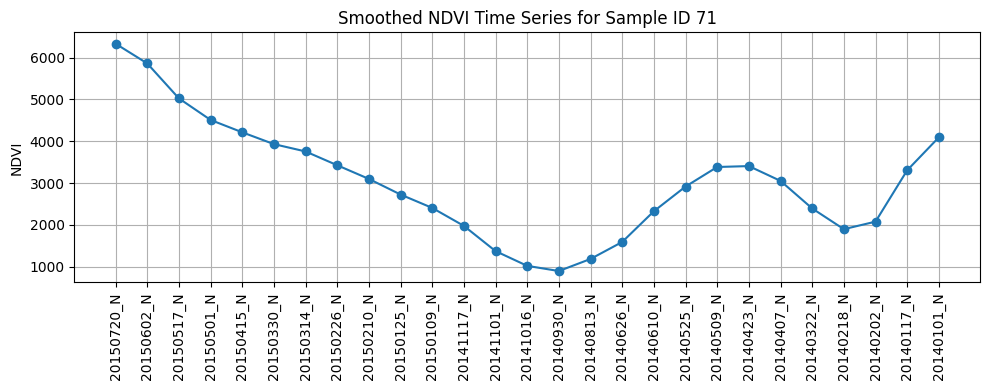

In [17]:

import numpy as np

# Define a rolling window function for rows
def row_rolling_mean(row, window=3):
    return pd.Series(row).rolling(window=window, center=True, min_periods=1).mean().values
# Apply across all rows
df_train[ndvi_cols] = df_train[ndvi_cols].apply(lambda row: row_rolling_mean(row), axis=1, result_type='broadcast')
import matplotlib.pyplot as plt
# Visualize smoothed NDVI curve for a sample
sample_id = 42  # change this index as needed
plt.figure(figsize=(10, 4))
plt.plot(ndvi_cols, df_train.loc[sample_id, ndvi_cols], marker='o')
plt.xticks(rotation=90)
plt.title(f"Smoothed NDVI Time Series for Sample ID {df_train.loc[sample_id, 'ID']}")
plt.ylabel("NDVI")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# Function to extract features
def extract_features(df, ndvi_cols):
    features = pd.DataFrame()

    # Statistical features
    features['ndvi_mean'] = df[ndvi_cols].mean(axis=1)
    features['ndvi_std'] = df[ndvi_cols].std(axis=1)
    features['ndvi_max'] = df[ndvi_cols].max(axis=1)
    features['ndvi_min'] = df[ndvi_cols].min(axis=1)
    features['ndvi_range'] = features['ndvi_max'] - features['ndvi_min']

    # Temporal peak/min locations
    features['ndvi_argmax'] = df[ndvi_cols].idxmax(axis=1).apply(lambda x: int(x.split('_')[0]))
    features['ndvi_argmin'] = df[ndvi_cols].idxmin(axis=1).apply(lambda x: int(x.split('_')[0]))

    # Shape statistics
    from scipy.stats import skew, kurtosis
    features['ndvi_skew'] = df[ndvi_cols].apply(skew, axis=1)
    features['ndvi_kurtosis'] = df[ndvi_cols].apply(kurtosis, axis=1)

    # NDVI change: difference between max and min position values
    ndvi_diff = df[ndvi_cols].diff(axis=1)
    features['ndvi_max_diff'] = ndvi_diff.max(axis=1)
    features['ndvi_mean_diff'] = ndvi_diff.mean(axis=1)

    # Seasonal NDVI: average in first 6 months vs last 6 months (rough cut)
    first_half = ndvi_cols[:13]
    second_half = ndvi_cols[13:]
    features['ndvi_seasonal_diff'] = df[first_half].mean(axis=1) - df[second_half].mean(axis=1)

    # Count low-vegetation observations
    features['ndvi_low_count'] = (df[ndvi_cols] < 0.1).sum(axis=1)

    return features
X_features = extract_features(df_train, ndvi_cols)
print("Feature shape:", X_features.shape)
X_features.head()



Feature shape: (8000, 13)


,ndvi_mean,ndvi_std,ndvi_max,ndvi_min,ndvi_range,ndvi_argmax,ndvi_argmin,ndvi_skew,ndvi_kurtosis,ndvi_max_diff,ndvi_mean_diff,ndvi_seasonal_diff,ndvi_low_count
0,-102.500977,390.287053,604.722815,-799.445209,1404.168024,20140930,20150415,-0.143203,-0.802945,285.257369,-29.407037,-397.614549,15
1,-253.478983,332.287912,405.241886,-721.405529,1126.647414,20141016,20150330,0.385307,-0.970859,301.224544,-26.464962,-201.413258,21
2,-724.449880,584.840751,123.824772,-2239.156040,2362.980812,20141016,20140101,-0.634667,0.258797,389.097064,-58.146650,-118.473390,25
3,-294.722064,762.496556,921.921034,-2113.055480,3034.976515,20150720,20140101,-0.517653,-0.096990,402.565488,-116.729866,355.042969,18
4,809.680380,655.849169,1929.158057,-862.272649,2791.430706,20150415,20140101,-0.467933,0.296721,481.520447,-71.812057,459.930263,2


Label mapping: {'farm': np.int64(0), 'forest': np.int64(1), 'grass': np.int64(2), 'impervious': np.int64(3), 'orchard': np.int64(4), 'water': np.int64(5)}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Validation Accuracy: 0.0625
              precision    recall  f1-score   support

        farm       0.00      0.00      0.00       168
      forest       0.67      0.01      0.01      1232
       grass       0.03      0.31      0.05        39
  impervious       0.19      0.49      0.28       134
     orchard       0.01      0.67      0.01         6
       water       0.10      0.52      0.17        21

    accuracy                           0.06      1600
   macro avg       0.17      0.33      0.09      1600
weighted avg       0.53      0.06      0.04      1600



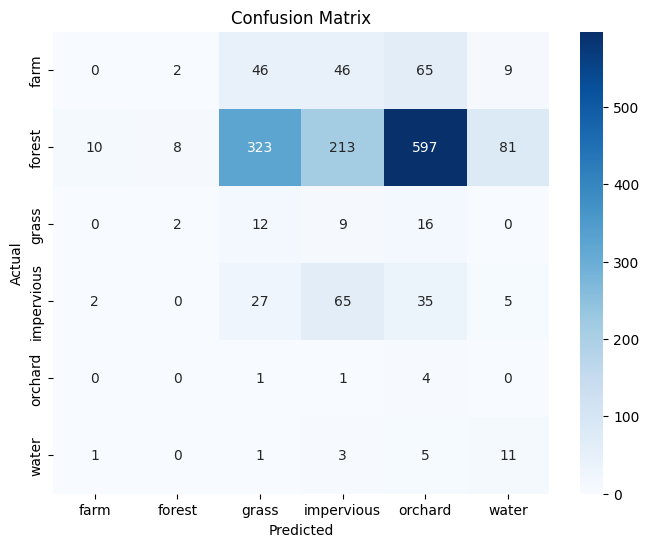

In [19]:
from sklearn.preprocessing import LabelEncoder

# Create encoder and fit to the 'class' column
le = LabelEncoder()
y = le.fit_transform(df_train['class'])

# You can check the mappings
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)


from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_features, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.linear_model import LogisticRegression

# Multinomial logistic regression
clf = LogisticRegression(
    multi_class='multinomial',
    solver='saga',           # 'sag' or 'saga' works with multinomial
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
clf.fit(X_train_scaled, y_train)


from sklearn.metrics import classification_report, accuracy_score

# Predictions
y_pred = clf.predict(X_val_scaled)

# Accuracy
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

# Full report
print(classification_report(y_val, y_pred, target_names=le.classes_))


import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


/usr/local/lib/python3.11/dist-packages/pandas/core/missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)


✅ Missing values after preprocessing: 0


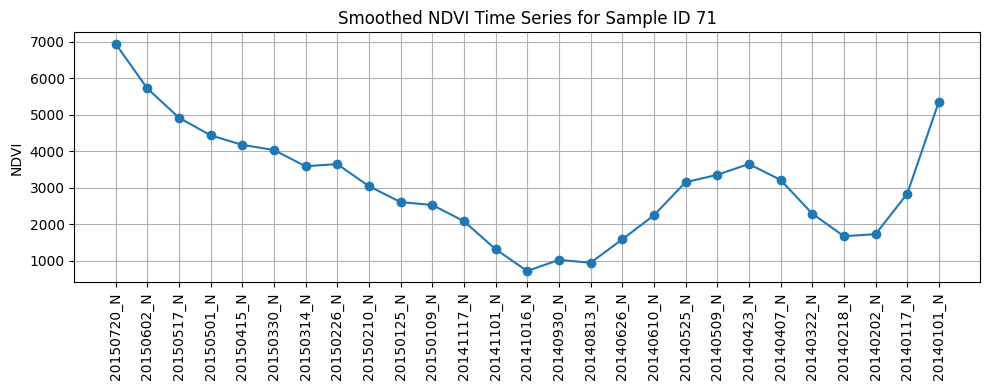

<ipython-input-15-555cd8d1fd63>:85: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_features['ndvi_slope'].fillna(X_features['ndvi_slope'].mean(), inplace=True)


Label mapping: {'farm': np.int64(0), 'forest': np.int64(1), 'grass': np.int64(2), 'impervious': np.int64(3), 'orchard': np.int64(4), 'water': np.int64(5)}

🔍 Original training class distribution: Counter({np.int64(1): 4927, np.int64(0): 673, np.int64(3): 535, np.int64(2): 157, np.int64(5): 84, np.int64(4): 24})
✅ Resampled training class distribution: Counter({np.int64(1): 4927, np.int64(0): 4927, np.int64(5): 4927, np.int64(3): 4927, np.int64(2): 4927, np.int64(4): 4927})
Best Params: {'C': 100, 'class_weight': 'balanced', 'max_iter': 5000, 'solver': 'saga'}
Accuracy: 0.540625
Report:
               precision    recall  f1-score   support

        farm       0.31      0.49      0.38       168
      forest       0.94      0.52      0.67      1232
       grass       0.11      0.59      0.19        39
  impervious       0.63      0.74      0.68       134
     orchard       0.02      0.67      0.04         6
       water       0.20      0.81      0.32        21

    accuracy              

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🎯 Validation Accuracy after SMOTE: 0.5319

📄 Classification Report after SMOTE:
              precision    recall  f1-score   support

        farm       0.31      0.49      0.38       168
      forest       0.94      0.51      0.66      1232
       grass       0.10      0.59      0.18        39
  impervious       0.64      0.73      0.69       134
     orchard       0.02      0.67      0.04         6
       water       0.20      0.86      0.33        21

    accuracy                           0.53      1600
   macro avg       0.37      0.64      0.38      1600
weighted avg       0.82      0.53      0.61      1600


🎯 Validation Accuracy after SMOTE: 0.5319

📄 Classification Report after SMOTE:
              precision    recall  f1-score   support

        farm       0.31      0.49      0.38       168
      forest       0.94      0.51      0.66      1232
       grass       0.10      0.59      0.18        39
  impervious       0.64      0.73      0.69       134
     orchard       0.02 

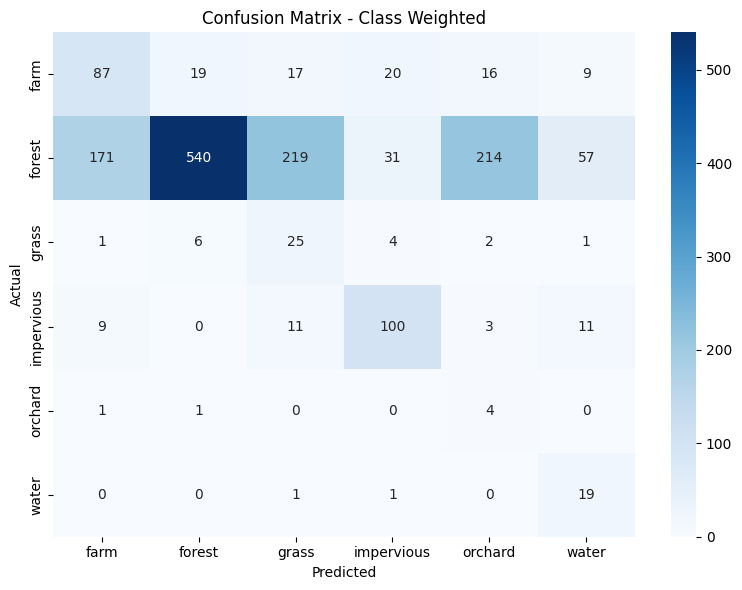

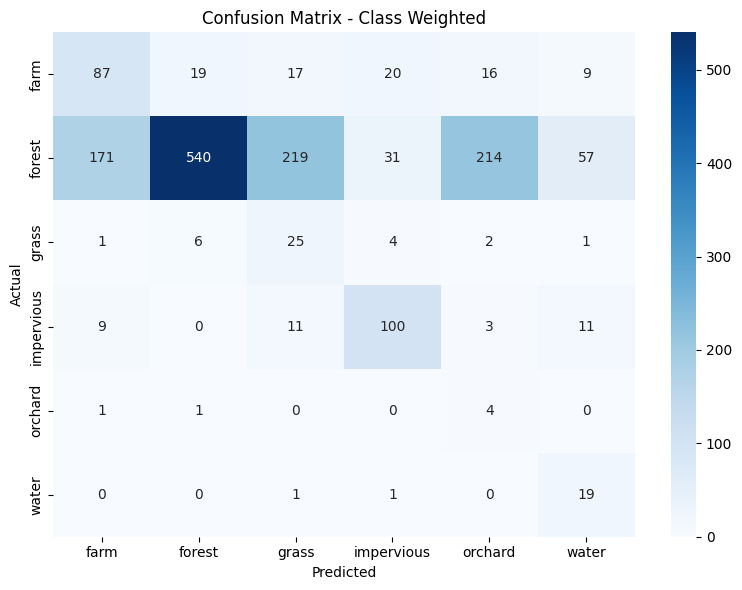

In [15]:
# --- 📦 Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from collections import Counter

# --- 📥 Load Dataset ---
df_train = pd.read_csv('/content/hacktrain.csv')

# --- 🔍 Identify NDVI Columns ---
ndvi_cols = [col for col in df_train.columns if '_N' in col]

# --- 🧼 Preprocessing ---
# Convert NDVI columns to numeric
for col in ndvi_cols:
    df_train[col] = pd.to_numeric(df_train[col], errors='coerce')

# Copy for interpolation
ndvi_df_temp = df_train[ndvi_cols].copy()
ndvi_df_temp.columns = np.arange(len(ndvi_cols))  # Temporarily rename to numeric

# 1. Spline Interpolation
ndvi_df_temp = ndvi_df_temp.interpolate(method='spline', order=3, axis=1, limit_direction='both')

# 2. Median imputation (for rows still containing NaN)
imputer = SimpleImputer(strategy='median')
ndvi_df_temp = pd.DataFrame(imputer.fit_transform(ndvi_df_temp), columns=ndvi_df_temp.columns, index=ndvi_df_temp.index)

# Restore original column names
ndvi_df_temp.columns = ndvi_cols
df_train[ndvi_cols] = ndvi_df_temp

# 3. Savitzky-Golay Smoothing
window_length = min(11, len(ndvi_cols) - 1 if len(ndvi_cols) % 2 == 0 else len(ndvi_cols))
window_length = max(3, window_length - (1 - window_length % 2))  # Ensure odd and >=3
polyorder = min(3, window_length - 1)
df_train[ndvi_cols] = df_train[ndvi_cols].apply(lambda row: savgol_filter(row, window_length=window_length, polyorder=polyorder), axis=1, result_type='broadcast')

print("✅ Missing values after preprocessing:", df_train[ndvi_cols].isnull().sum().sum())

# --- 📈 Plot NDVI for Sample ---
sample_id = 42
plt.figure(figsize=(10, 4))
plt.plot(ndvi_cols, df_train.loc[sample_id, ndvi_cols], marker='o')
plt.xticks(rotation=90)
plt.title(f"Smoothed NDVI Time Series for Sample ID {df_train.loc[sample_id, 'ID']}")
plt.ylabel("NDVI")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 🧪 Feature Engineering ---
X_features = pd.DataFrame()
X_features['ndvi_mean'] = df_train[ndvi_cols].mean(axis=1)
X_features['ndvi_median'] = df_train[ndvi_cols].median(axis=1)
X_features['ndvi_std'] = df_train[ndvi_cols].std(axis=1)
X_features['ndvi_min'] = df_train[ndvi_cols].min(axis=1)
X_features['ndvi_max'] = df_train[ndvi_cols].max(axis=1)
X_features['ndvi_range'] = X_features['ndvi_max'] - X_features['ndvi_min']
X_features['ndvi_skew'] = df_train[ndvi_cols].skew(axis=1)
X_features['ndvi_kurt'] = df_train[ndvi_cols].kurt(axis=1)
X_features['ndvi_q25'] = df_train[ndvi_cols].quantile(0.25, axis=1)
X_features['ndvi_q75'] = df_train[ndvi_cols].quantile(0.75, axis=1)

# Slope feature
slopes = []
for idx in range(len(df_train)):
    y_vals = df_train.loc[idx, ndvi_cols].astype(float).values
    x_vals = np.arange(len(y_vals))
    valid_indices = ~np.isnan(y_vals)
    if np.sum(valid_indices) >= 2:
        slope, _ = np.polyfit(x_vals[valid_indices], y_vals[valid_indices], 1)
        slopes.append(slope)
    else:
        slopes.append(np.nan)
X_features['ndvi_slope'] = slopes
X_features['ndvi_slope'].fillna(X_features['ndvi_slope'].mean(), inplace=True)

# Append raw NDVI values
X_features = pd.concat([X_features, df_train[ndvi_cols]], axis=1)

# --- 🏷️ Label Encoding ---
le = LabelEncoder()
y = le.fit_transform(df_train['class'])
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_map)

# --- 📚 Train-Test Split ---
X_train, X_val, y_train, y_val = train_test_split(X_features, y, test_size=0.2, random_state=42, stratify=y)

# --- 📏 Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# --- ⚖️ SMOTE Balancing ---
print(f"\n🔍 Original training class distribution: {Counter(y_train)}")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print(f"✅ Resampled training class distribution: {Counter(y_train_resampled)}")

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Lower = stronger regularization
    'solver': ['saga'],
    'max_iter': [5000],
    'class_weight': ['balanced']
}

grid = GridSearchCV(LogisticRegression(penalty='l2', random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_resampled, y_train_resampled)

print("Best Params:", grid.best_params_)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_val_scaled)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Report:\n", classification_report(y_val, y_pred, target_names=le.classes_))

# --- 📊 Logistic Regression with SMOTE ---
clf_smote = LogisticRegression(penalty= None, solver='sag', max_iter=1000, random_state=42)
clf_smote.fit(X_train_resampled, y_train_resampled)

y_pred_smote = clf_smote.predict(X_val_scaled)
acc_smote = accuracy_score(y_val, y_pred_smote)
print(f"\n🎯 Validation Accuracy after SMOTE: {acc_smote:.4f}")
print("\n📄 Classification Report after SMOTE:")
print(classification_report(y_val, y_pred_smote, target_names=le.classes_))

# --- 📚 Logistic Regression with Class Weights (no SMOTE) + Cross-Validation ---
clf_weighted = LogisticRegression(solver='saga', class_weight='balanced', max_iter=5000, C=0.1, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf_weighted, X_train_scaled, y_train, cv=kf, scoring='accuracy')

print(f"\n📊 Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}, Std Dev: {np.std(cv_scores):.4f}")

clf_weighted.fit(X_train_scaled, y_train)
y_pred = clf_weighted.predict(X_val_scaled)

print("\n📄 Classification Report (Class Weighted):")
print(classification_report(y_val, y_pred, target_names=le.classes_))

# --- 📉 Confusion Matrix ---
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Class Weighted")
plt.tight_layout()
plt.show()
